# Imports

In [1]:
import numpy as np
import pandas as pd

from sir import sir

# Default inputs

In [2]:
START_DATE = "2020-03-15"
FIPS = 36061
BETA_PERCENTILE = 50
GAMMA = 1/14
START_DAY = 0
STOP_DAY = 100

# Injected inputs

In [3]:
# Parameters
FIPS = 17031
BETA_PERCENTILE = None
START_DATE = "2020-04-13"


# Constants

In [4]:
TODAY = pd.Timestamp.today().date()
START_DATE = pd.Timestamp(START_DATE).date()

In [5]:
INPUT_FILE_NAME = f"{TODAY}_{FIPS}_betas.csv"
OUTPUT_FILE_NAME = f"{START_DATE}_{TODAY}_{FIPS}_{BETA_PERCENTILE}_sir-model-output.csv"

# Read in beta value

In [6]:
df = pd.read_csv(INPUT_FILE_NAME).set_index("percentile")
beta = df.loc[BETA_PERCENTILE, "beta"] if BETA_PERCENTILE is not None else None

# Read in USA FACTS data

In [7]:
case_df = pd.read_csv(
    "https://usafactsstatic.blob.core.windows.net/"
    "public/data/covid-19/covid_confirmed_usafacts.csv",
)

case_df = case_df[case_df["countyFIPS"] == FIPS].melt(
    # Melt dataframe (wide to long format)
    id_vars=["countyFIPS", "County Name", "State", "stateFIPS"],
    value_name="confirmed",
    var_name="date",
).astype({"date": "datetime64"})

In [8]:
# Create a day variable from the date variable
case_df = case_df.assign(
    days=(case_df["date"] - case_df["date"].min()).dt.days
)

# Trim up to but not including day 30
case_df = case_df[case_df["days"].ge(30)]

# Reverse order (highest to lowest day)
case_df = case_df.sort_values("days", ascending=False)

# Replace incorrect values with missing values
while case_df["confirmed"].pct_change().gt(0).any():
    case_df.loc[
        case_df["confirmed"].pct_change().gt(0),
        "confirmed",
    ] = np.nan

# Replace missing values with previous values
case_df.assign(
    confirmed=case_df["confirmed"].ffill()
)

# Restore the original order (lowest to highest day)
case_df = case_df.sort_values(["countyFIPS", "days"])

case_df = case_df.assign(
    # Calculate new cases from confirmed cases
    new_cases=case_df["confirmed"]
    .diff()
    .fillna(0)
)

# Read in county population data

In [9]:
cens_df = pd.read_csv(
    "https://www2.census.gov/programs-surveys/popest/datasets/"
    "2010-2019/counties/totals/co-est2019-alldata.csv",
    usecols=[
        "STATE",
        "COUNTY",
        "STNAME",
        "CTYNAME",
        "POPESTIMATE2019"
    ],
    encoding="latin-1"
)

# Combine state and county fips
cens_df = cens_df.assign(
    county_fips=(
        cens_df["STATE"].astype(str)
        + cens_df["COUNTY"].astype(str).str.zfill(3)
    ).astype(int)
)

In [10]:
# pop_df = pd.read_csv(
#     "https://usafactsstatic.blob.core.windows.net/"
#     "public/data/covid-19/covid_county_population_usafacts.csv",
#     ).set_index("countyFIPS").drop(
#         # Remove unallocated cases (FIPS 0)
#         0
#     ).reset_index()
# pop_df.head()

# Add population to case data

In [11]:
df = case_df.assign(
    population=float(
        cens_df.loc[
        cens_df["county_fips"] == FIPS,
        "POPESTIMATE2019"
        ]
    )
).set_index("date")

# Calculate growth_rate, doubling time, beta, and Rt

$\Huge r = \frac{new\_cases_t - new\_cases_{t-1}}{new\_cases_{t-1}}$

$\Huge T_d=\frac{ln(2)}{ln(r+1)}$

$\Huge \beta=\frac{r+\gamma}{N}$

$\Huge R_t=e^{r\cdot T_c}=\frac{\beta \cdot N}{\gamma}=\frac{r + \gamma}{\gamma}$

$\Huge T_c=\frac{ln(\frac{\beta \cdot N}{\gamma})}{r}=\frac{ln(\frac{r + \gamma}{\gamma})}{r}$

In [12]:
# %% Growth rate
df = df.assign(
    susceptible=df["population"] - (df["confirmed"] * 10),
    gr=df["new_cases"].pct_change() / df["days"].diff(),
)

# Remove infinite and missing growth rates 
df["gr"] = df["gr"].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["gr"])

# Doubling time, beta, and Rt
df = df.assign(
    tc=np.log((df["gr"] + GAMMA) / GAMMA) / df["gr"],
    dt=np.log(2) / np.log(df["gr"] + 1),
    beta=(df["gr"] + GAMMA) / df["susceptible"],
)

# If growth rate is zero, Rt = e^0 = 1, regardless of the value of Tc
df.loc[df["gr"]==0, "tc"] = 0

df = df.assign(
    # Calculate 7-day moving average of growth rate
    smooth_gr=df["gr"].rolling(
        window=7,
        min_periods=1
    ).mean(),
    # Calculate 7-day moving average of mean generation interval
    smooth_tc=df["tc"].rolling(
        window=7,
        min_periods=1
    ).mean(),
)

df["e^r"] = np.exp(df["gr"])
df["e^smooth_r"] = np.exp(df["smooth_gr"])
df["r+gamma"] = df["gr"]+GAMMA

df = df.assign(
    smooth_dt=np.log(2) / np.log(df["smooth_gr"] + 1),
    smooth_beta=(df["smooth_gr"] + GAMMA) / df["susceptible"],
    new_rt=np.exp(df["gr"]*df["tc"]),
    old_rt=(df["gr"] + GAMMA) / GAMMA,
    new_smooth_rt=np.exp(df["smooth_gr"]*df["smooth_tc"]),
    old_smooth_rt=(df["smooth_gr"] + GAMMA) / GAMMA,
)

/Users/martinskarzynski/miniconda/envs/py/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/martinskarzynski/miniconda/envs/py/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


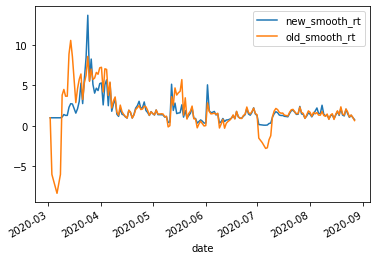

In [13]:
df[["new_smooth_rt", "old_smooth_rt",]].plot();

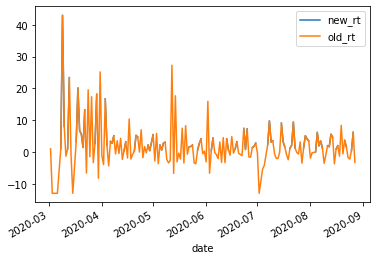

In [14]:
df[["new_rt", "old_rt",]].plot();

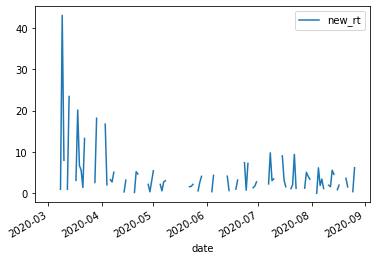

In [15]:
df[["new_rt"]].plot();

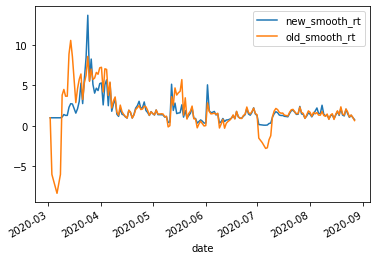

In [16]:
df[["new_smooth_rt", "old_smooth_rt"]].plot();

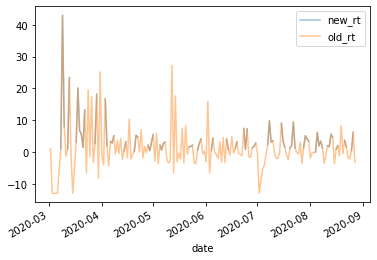

In [17]:
df[["new_rt", "old_rt"]].plot(alpha=.45);

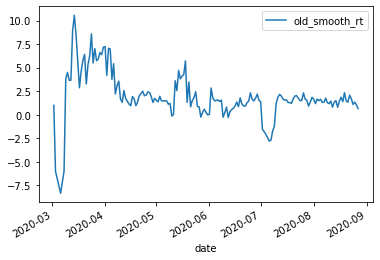

In [18]:
df[["old_smooth_rt"]].plot();

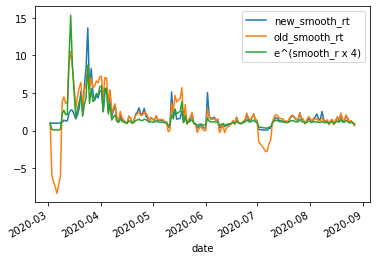

In [19]:
df[["new_smooth_rt", "old_smooth_rt"]].join(
    df["e^smooth_r"].pow(4).rename("e^(smooth_r x 4)")
).plot();

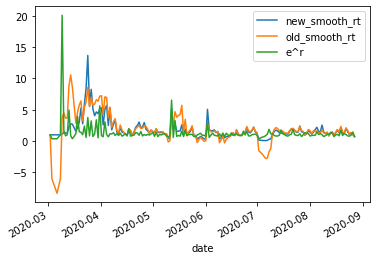

In [20]:
df[["new_smooth_rt", "old_smooth_rt"]].join(
    df["e^r"]
).plot();

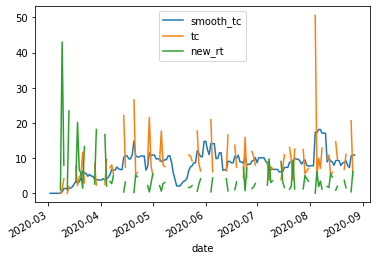

In [21]:
df[["smooth_tc", "tc", "new_rt"]].plot();

In [22]:
df[["tc", "r+gamma", "gr"]]

,tc,r+gamma,gr
date,,,
2020-03-02,0.000000,0.071429,0.000000
2020-03-03,NaN,-0.928571,-1.000000
2020-03-06,NaN,-0.928571,-1.000000
2020-03-08,0.000000,0.071429,0.000000
2020-03-09,1.253733,3.071429,3.000000
...,...,...,...
2020-08-23,NaN,-0.125755,-0.197183
2020-08-24,NaN,-0.160690,-0.232119
2020-08-25,20.644609,0.031007,-0.040422


# Run the model using the provided beta and start date

In [ ]:
pd.DataFrame(
    sir(
        susceptible=df.loc[START_DATE, "susceptible"],
        infected=df.loc[START_DATE, "confirmed"],
        recovered=0,
        beta=beta if beta else df.loc[START_DATE, "smooth_beta"],
        gamma=GAMMA,
        start=START_DAY,
        stop=STOP_DAY
    ),
    columns=["day", "susceptible", "infected", "recovered"]
).to_csv(OUTPUT_FILE_NAME, index=False)

## Goal
There is a need to rapidy produce models for a variety of start dates and scenarios, both for OWS and Dr. Butler weekly modeling exercises. Currently, Advana does not have the capability to produce model results that do not adhere to the system already established to run on a regular interval, and for scenarios not yet programmed into Advana. The goal of this workbook is to support the Epi team with the ability to produce model results in an easy and automated way, both for analysis and for dissemination.

Functionaly, the Epis will need to be able to pull the following levers:
- The date the model starts
- A desired beta (i.e. 1/3 between full mitigation and no mitigation)
- The county for which the model is run

Currently these functions exist, but they need to be made more user friendly. Possible improvements to functionality include:
- Allow the user to specify the model start date once (currently requires entry twice)
- Allow the user to enter multiple sets of betas and run all models at once (currently only take one beta)
- Allow the user to enter multiple starting dates and run all models at once (currently only takes one starting date)
- Allow for the aggregation of the model results for each county requested. We commonly want to roll-up multiple counties that fall in the same catchment area for an MTF.
- Produce historical case counts for all counties requested (currently saves the full case history in one excel file and attaches case history that overlaps with the time period of the model in the same excel file as the model output. 
- Produces line charts with the model results, and idealy case count history for a length specified by the user
- Ability to run a model that is status quo on day zero, then alter the beta on a set date. Ex 1/3 Release Day 15

Athough this would be nice in dashboard form, speed in development is more important than pure ease-of-use.